In [73]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### In this notebook, I'm going to use data scraped from Wikipedia to obtain a sense of whether or not there is a correlation between economic disparity and gun violence.

I relied heavily on this article: https://medium.com/analytics-vidhya/web-scraping-wiki-tables-using-beautifulsoup-and-python-6b9ea26d8722

### First, I'm going to read in my 'gun deaths by state' csv file as a Pandas dataframe.

In [74]:
gd = pd.read_csv('./data/gd_state.csv')

### Now I'm going to start scraping Wikipedia for additional information. I'll start with a table of US states by population.

In [75]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population').text

In [76]:
soup = bs(url,'lxml')

In [77]:
table = soup.find('table',{'class':'wikitable sortable'})

In [78]:
table_df = pd.read_html(str(table),header=0)

In [79]:
table_df = table_df[0]

In [80]:
table_df.head()

,"Rank in the fifty U.S. states, 2017","Rank in all U.S. states and territories, 2010",State or territory,"Population estimate, July 1, 2017[4]","Census population, April 1, 2010",Percent increase from 2010-2017[note 1],"Total seats in the U.S. House of Representatives, 2013–2023","Estimated population per electoral vote, 2017[note 2]","Estimated population per House seat, 2017","Census population per House seat, 2010","Percent of the total U.S. population, 2017[note 3]"
0,NaN,NaN,California,39536653,37252895,6.13%,NaN,718848,745974,702885,12.14%
1,NaN,NaN,Texas,28304596,25146105,12.56%,NaN,744858,786238,698503,8.69%
2,NaN,NaN,Florida,20984400,18804623,11.59%,NaN,734904,777200,696468,6.44%
3,NaN,NaN,New York,19849399,19378087,2.43%,NaN,684462,735163,717707,6.09%
4,NaN,NaN,Pennsylvania,12805537,12702887,0.81%,NaN,640277,711419,705715,3.93%


In [81]:
table_df = table_df[['State or territory', 'Population estimate, July 1, 2017[4]']]

In [82]:
table_df.rename(columns={'State or territory':'state',
                           'Population estimate, July 1, 2017[4]':'pop'}, inplace=True)

In [83]:
table_df.set_index('state', inplace=True)

In [84]:
table_df.tail(20)

,pop
state,
District of Columbia,693972
Vermont,623657
Wyoming,579315
Guam,"165,718[5]"
U.S. Virgin Islands,"104,914[7]"
American Samoa,"55,641[9]"
Northern Mariana Islands,"55,194[11]"
Wake Island,100
Palmyra Atoll,20


In [85]:
table_df.drop(['Guam', 'Puerto Rico', 'U.S. Virgin Islands', 'American Samoa', 'Northern Mariana Islands',
              'Wake Island', 'Palmyra Atoll', 'Johnston Atoll', 'Baker Island', 'Howland Island', 'Midway Atoll',
              'Palmyra Atoll', 'Jarvis Island', 'Kingman Reef', 'Navassa Island', 'Contiguous United States', 
              'The fifty states', 'Fifty states + D.C.', 'Total U.S. (including D.C. and territories)'], 
              inplace=True)

## Merging dataframes:

In [89]:
gd.set_index('state', inplace=True)

In [90]:
states = pd.merge(table_df, gd, left_index=True, right_index=True)

In [116]:
states.head()

,pop,n_killed,pc_killed
state,,,
California,39536653,5562,14.067959
Texas,28304596,5046,17.827493
Florida,20984400,3909,18.628124
New York,19849399,1705,8.589681
Pennsylvania,12805537,2395,18.702847


In [92]:
states.dtypes

pop         object
n_killed     int64
dtype: object

In [93]:
states['pop'] = states['pop'].astype('int64')

In [94]:
states['pc_killed'] = (states.n_killed / states['pop']) * 100000

In [95]:
states.head()

,pop,n_killed,pc_killed
state,,,
California,39536653,5562,14.067959
Texas,28304596,5046,17.827493
Florida,20984400,3909,18.628124
New York,19849399,1705,8.589681
Pennsylvania,12805537,2395,18.702847


In [102]:
states_sorted = states.sort_values('pc_killed', ascending=False)

### I'll go ahead and save this dataframe as a csv file so I can use it to create a Tableau plot later:

In [118]:
states_sorted.to_csv('./data/states_pc.csv')

### I also want to make a barplot to better interpret how the states compare with one another. I'm going to highlight Maryland because I'll be focusing more on it later--Baltimore specifically--and I want to show how looking at per capita rates by states might not be granular enough for our purposes. 

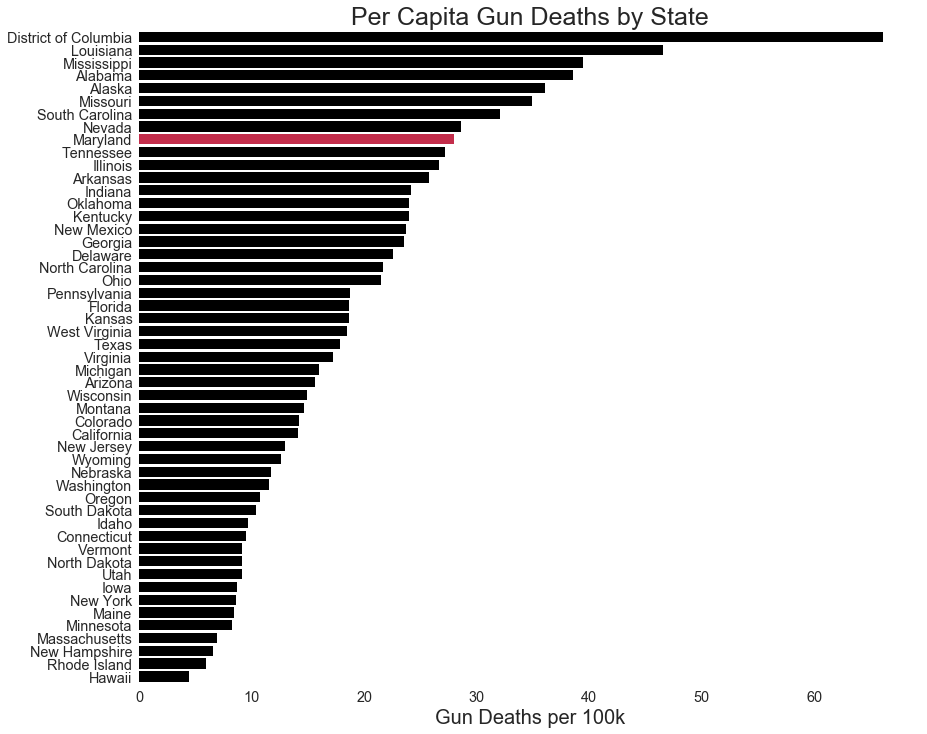

In [117]:
sns.set_style("white")
f, ax = plt.figure(figsize=(14,12)), plt.gca()
colors = colors = ['crimson' if x=='Maryland' else 'black' for x in states_sorted.index]
sns.barplot(x=states_sorted.pc_killed, y=states_sorted.index, data=states_sorted, palette=colors)
plt.title("Per Capita Gun Deaths by State", fontsize=25)
plt.xlabel("Gun Deaths per 100k", fontsize=20)
plt.ylabel('')
ax.tick_params(labelsize='x-large')
sns.despine(left=True, bottom=True)
plt.savefig('./images/states_pc.png');

## Seeking a global perspective:

### I want to get a sense of how the US compares with other countries around the world in terms of gun violence. To do this, I'll scrape some more tables from Wikipedia, then merge and plot them accordingly.

In [35]:
url2 = requests.get('https://en.wikipedia.org/wiki/Estimated_number_of_civilian_guns_per_capita_by_country').text

soup2 = bs(url2,'lxml')

table2 = soup2.find('table',{'class':'wikitable sortable'})

table_df2 = pd.read_html(str(table2),header=0)

In [36]:
table_df2 = table_df2[0]

In [37]:
table_df2.head()

,Country,Civilian-heldfirearms per100 population,Notes
0,United States,120.5,[note 1]
1,Yemen,52.8,NaN
2,Serbia,39.1,NaN
3,Montenegro,39.1,NaN
4,Canada,34.7,NaN


In [38]:
table_df2.columns = map(str.lower, table_df2.columns)

In [39]:
table_df2.rename(columns={'civilian-heldfirearms per100 population':'guns_per_100_ppl'}, inplace=True)

In [40]:
table_df2.set_index("country", inplace=True)

In [41]:
table_df2.drop('notes', axis=1, inplace=True)

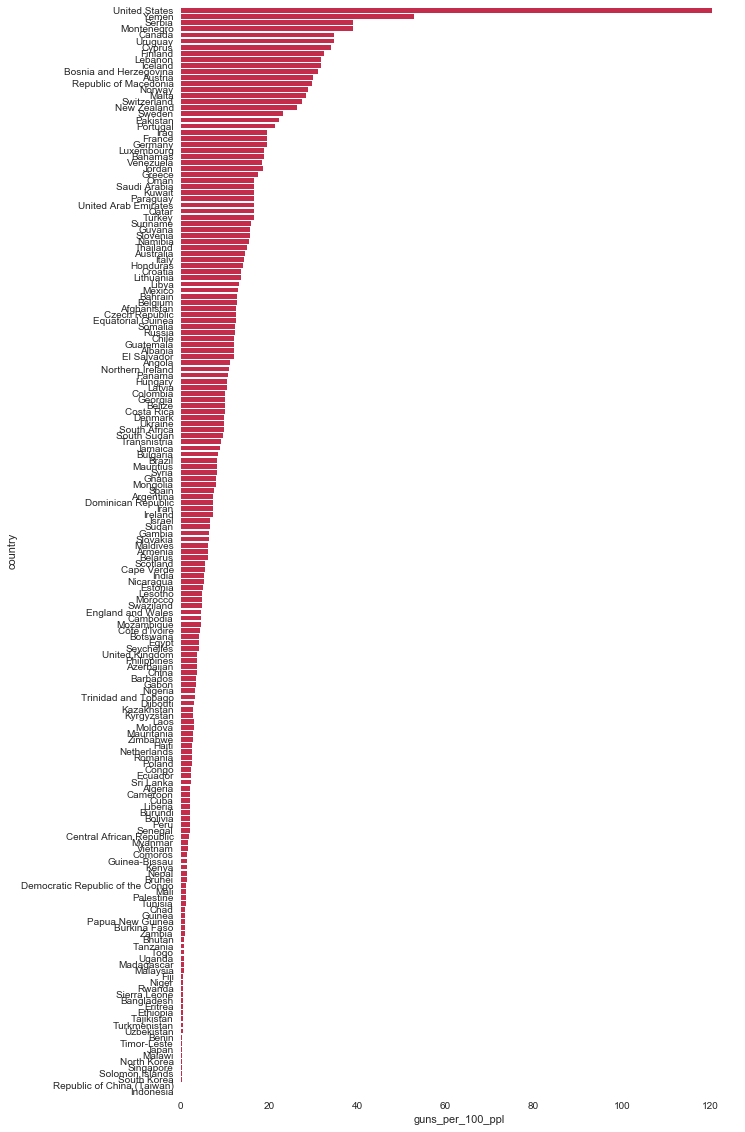

In [42]:
f, ax = plt.subplots(figsize=(10, 20))

sns.barplot(x="guns_per_100_ppl", y=table_df2.index, data=table_df2,
            color="crimson")
ylabel=""
xlabel="Per Capita Gun Ownership by Country"
sns.despine(left=True, bottom=True)

### Yikes... this plot is cmpletely unreadable. However, if I drop about 75% of the countries, focusing solely on Western nations and other nations w/ similar gun violence to the US, I think it might be farily informative.

In [43]:
url3 = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_firearm-related_death_rate').text
soup3 = bs(url3,'lxml')
table3 = soup3.find('table',{'class':'wikitable sortable'})
table_df3 = pd.read_html(str(table3),header=0)

In [44]:
table_df3 = table_df3[0]

In [45]:
table_df3.head()

,Country,Year,Total,Homicides,Suicides,Unintentional,Undetermined,Guns per 100 inhabitants,Sources and notes
0,Argentina,2014,6.93,3.07,1.20,0.08,2.57,8.8 (2010),Guns in Argentina[1]
1,Australia,2016,1.04,0.18,0.8,0.02,0.01,13.70,Guns in Australia[2]
2,Austria,2014,2.9,0.12,2.69,0.02,0.09,30.4 (2007?),Guns in Austria[3]
3,Azerbaijan,2007,0.07,0.27 (2010),0.01,0.02,?,3.5,Guns in Azerbaijan[4]
4,Barbados,2011,6.6,3.12 (2013),?,0.35,4.88,3.5 (2007),Guns in Barbados[5]


In [46]:
table_df3.set_index('Country', inplace=True)

In [47]:
table_df3.head()

,Year,Total,Homicides,Suicides,Unintentional,Undetermined,Guns per 100 inhabitants,Sources and notes
Country,,,,,,,,
Argentina,2014,6.93,3.07,1.20,0.08,2.57,8.8 (2010),Guns in Argentina[1]
Australia,2016,1.04,0.18,0.8,0.02,0.01,13.70,Guns in Australia[2]
Austria,2014,2.9,0.12,2.69,0.02,0.09,30.4 (2007?),Guns in Austria[3]
Azerbaijan,2007,0.07,0.27 (2010),0.01,0.02,?,3.5,Guns in Azerbaijan[4]
Barbados,2011,6.6,3.12 (2013),?,0.35,4.88,3.5 (2007),Guns in Barbados[5]


In [48]:
table_df3.drop(['Year', 'Sources and notes'], axis=1, inplace=True)

In [49]:
table_df3.head()

,Total,Homicides,Suicides,Unintentional,Undetermined,Guns per 100 inhabitants
Country,,,,,,
Argentina,6.93,3.07,1.20,0.08,2.57,8.8 (2010)
Australia,1.04,0.18,0.8,0.02,0.01,13.70
Austria,2.9,0.12,2.69,0.02,0.09,30.4 (2007?)
Azerbaijan,0.07,0.27 (2010),0.01,0.02,?,3.5
Barbados,6.6,3.12 (2013),?,0.35,4.88,3.5 (2007)


In [50]:
len(table_df2)

179

In [51]:
global_gd = pd.merge(table_df2, table_df3, left_index=True, right_index=True)

In [52]:
len(global_gd)

72

In [53]:
global_gd.drop("Guns per 100 inhabitants", axis=1, inplace=True)

In [54]:
global_gd.columns = map(str.lower, global_gd.columns)

In [55]:
import regex as re

In [56]:
global_gd.undetermined.fillna('[3]', inplace=True)

In [57]:
pat = "\\[.+?\\]|\\(.+?\\)"
re_pat = re.compile(pat)
for i in global_gd.index:
    global_gd.loc[i,"homicides"] = re_pat.sub("", global_gd.loc[i,"homicides"])
for i in global_gd.index:
    global_gd.loc[i,"suicides"] = re_pat.sub("", global_gd.loc[i,"suicides"])
for i in global_gd.index:
    global_gd.loc[i,"unintentional"] = re_pat.sub("", global_gd.loc[i,"unintentional"])
for i in global_gd.index:
    global_gd.loc[i,"undetermined"] = re_pat.sub("", global_gd.loc[i,"undetermined"])

In [58]:
global_gd.dtypes

guns_per_100_ppl    float64
total                object
homicides            object
suicides             object
unintentional        object
undetermined         object
dtype: object

In [59]:
global_gd.replace('?', '9999' , inplace=True)

In [60]:
global_gd.head()

,guns_per_100_ppl,total,homicides,suicides,unintentional,undetermined
United States,120.5,11.96,4.62,7.10,0.15,0.09
Serbia,39.1,3.49,0.61,2.49,0.14,0.29
Montenegro,39.1,8.91,2.42,6.49,9999,9999
Canada,34.7,2.05,0.61,1.52,0.05,0.02
Uruguay,34.7,11.52,4.78,4.68,2.00,0.06


In [61]:
global_gd.isnull().sum()

guns_per_100_ppl    0
total               0
homicides           0
suicides            0
unintentional       0
undetermined        0
dtype: int64

In [62]:
global_gd[global_gd.values=='9999'].drop_duplicates()

,guns_per_100_ppl,total,homicides,suicides,unintentional,undetermined
Montenegro,39.1,8.91,2.42,6.49,9999,9999
Iceland,31.7,0.07,0.00,1.25,9999,9999
Qatar,16.7,0.15,0.15,9999,9999,9999
Honduras,14.1,60.00 (2015),66.64,0.41,0.13,9999
Ukraine,9.9,1.36,1.36,9999,9999,
Jamaica,8.8,30.72,30.38,0.34,9999,9999
Belarus,6.1,9999,0.14,9999,9999,9999
India,5.3,0.28,0.30,0.14,0.04,9999
Swaziland,4.8,37.16,37.16,9999,9999,9999
Philippines,3.6,8.90,8.90,9999,9999,9999


In [63]:
global_gd.loc['Honduras','total'] = '60.00'

In [64]:
global_gd.drop('undetermined', axis=1, inplace=True)

In [65]:
global_gd[global_gd.values=='9999'].drop_duplicates()

,guns_per_100_ppl,total,homicides,suicides,unintentional
Montenegro,39.1,8.91,2.42,6.49,9999
Iceland,31.7,0.07,0.00,1.25,9999
Qatar,16.7,0.15,0.15,9999,9999
Ukraine,9.9,1.36,1.36,9999,9999
Jamaica,8.8,30.72,30.38,0.34,9999
Belarus,6.1,9999,0.14,9999,9999
Swaziland,4.8,37.16,37.16,9999,9999
Philippines,3.6,8.90,8.90,9999,9999
Barbados,3.5,6.6,3.12,9999,0.35
Bolivia,2.0,9999,0.74,9999,9999


In [66]:
global_gd.drop("unintentional", axis=1, inplace=True)

In [67]:
global_gd[global_gd.values=='9999'].drop_duplicates()

,guns_per_100_ppl,total,homicides,suicides
Qatar,16.7,0.15,0.15,9999
Ukraine,9.9,1.36,1.36,9999
Belarus,6.1,9999,0.14,9999
Swaziland,4.8,37.16,37.16,9999
Philippines,3.6,8.90,8.90,9999
Barbados,3.5,6.6,3.12,9999
Bolivia,2.0,9999,0.74,9999


In [68]:
global_gd.drop(['Qatar', 'Ukraine', 'Belarus', 'Swaziland', 'Philippines', 'Barbados', 'Bolivia'], axis=0, inplace=True)

In [69]:
global_gd = global_gd.apply(pd.to_numeric, errors='coerce')

### I need to do some data cleaning... namely, I should remove one of the 'guns per capita' columns. However, they contain different values, so I first need to figure out which set of numbers is more accurate. I also need to drop countries that are immaterial to the scope of my problem statement as well as those that contain a great deal of missing values.

In [70]:
global_gd.sort_values('total', ascending=False).head()

,guns_per_100_ppl,total,homicides,suicides
Honduras,14.1,60.00,66.64,0.41
Venezuela,18.5,59.13,39.00,0.48
El Salvador,12.0,45.60,26.49,0.13
Guatemala,12.1,34.10,29.62,0.34
Jamaica,8.8,30.72,30.38,0.34


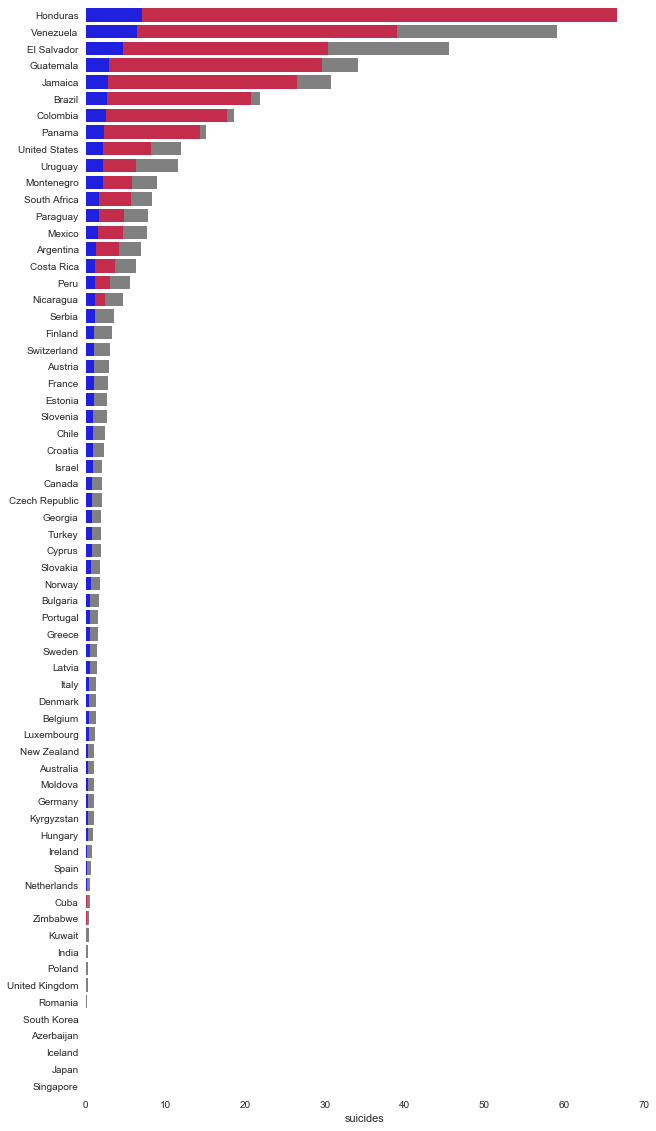

In [71]:
f, ax = plt.subplots(figsize=(10, 20))

sns.barplot(x="total", 
            y=global_gd.sort_values('total', ascending=False).index, 
            data=global_gd.sort_values('total', ascending=False),                                                                                  
            color="grey")
sns.barplot(x="homicides", 
            y=global_gd.sort_values('total', ascending=False).index, 
            data=global_gd.sort_values('homicides', ascending=False),                                                                                  
            color="crimson")
sns.barplot(x="suicides", 
            y=global_gd.sort_values('total', ascending=False).index, 
            data=global_gd.sort_values('suicides', ascending=False),                                                                                  
            color="blue")
ylabel=""
xlabel="Per Capita Gun Deaths Globally"
sns.despine(left=True, bottom=True)

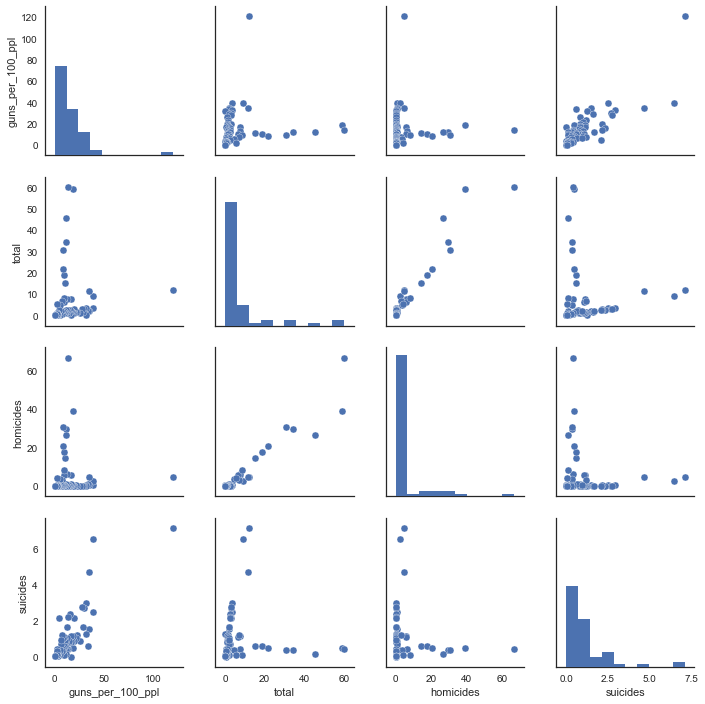

In [72]:
sns.pairplot(global_gd)

# Obtaining Global Gini Values

In [73]:
df = pd.read_csv('./worldbank_gini/cia_gini.txt', sep="([\d.]+%?)", header=None)

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [74]:
df.iloc[:,2] = df.iloc[:,2].str.strip()

In [75]:
df.drop([0, 1, 4], axis=1, inplace=True)

In [76]:
df.head(1)

,2,3
0,Lesotho,63.2


In [77]:
df.rename(columns={2:'country', 3:'gini'}, inplace=True)


In [78]:
df.set_index('country', inplace=True)

In [79]:
global_gd = pd.merge(global_gd, df, left_index=True, right_index=True)

In [80]:
global_gd.head()

,guns_per_100_ppl,total,homicides,suicides,gini
United States,120.5,11.96,4.62,7.10,45.0
Serbia,39.1,3.49,0.61,2.49,38.7
Montenegro,39.1,8.91,2.42,6.49,31.9
Canada,34.7,2.05,0.61,1.52,32.1
Uruguay,34.7,11.52,4.78,4.68,41.6


In [81]:
# for each value in column_x, calculate the mean column_y 
pd.DataFrame(global_gd.groupby('gini').total.mean())

,total
gini,
23.7,1.830
24.4,2.640
24.9,1.470
25.9,1.240
26.8,1.390
27.0,1.010
27.2,3.250
27.3,0.140
28.0,0.070


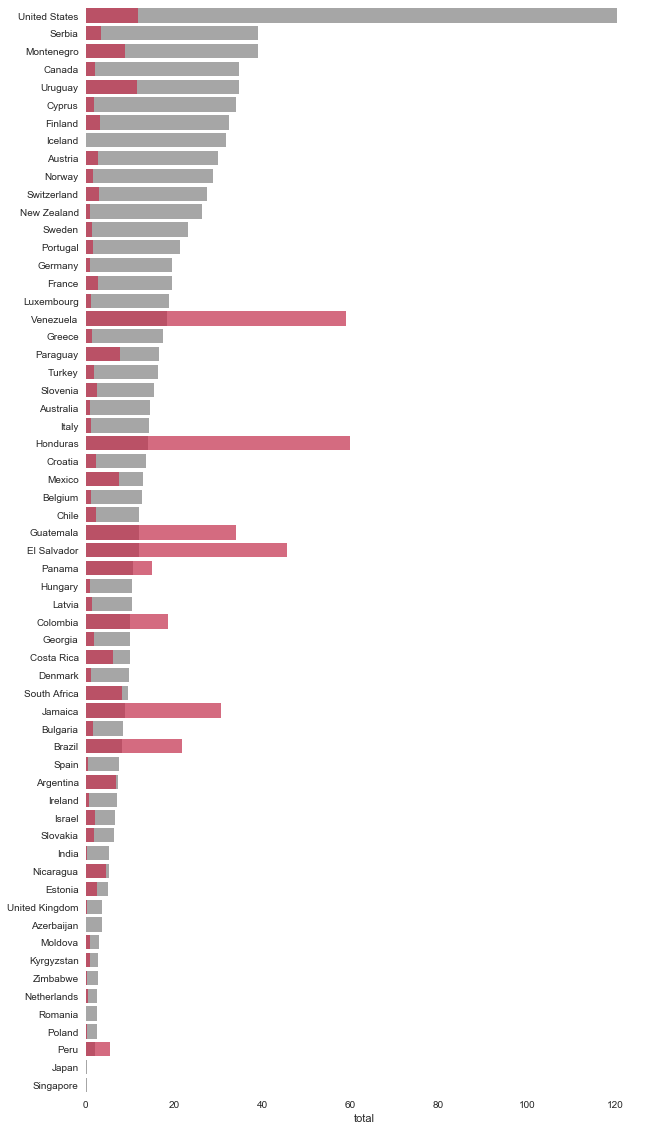

In [82]:
f, ax = plt.subplots(figsize=(10, 20))

sns.barplot(x="guns_per_100_ppl", 
            y=global_gd.sort_values('guns_per_100_ppl', ascending=False).index, 
            data=global_gd.sort_values('guns_per_100_ppl', ascending=False),                                                                                  
            color="grey",
            alpha=.7)
sns.barplot(x="total", 
            y=global_gd.sort_values('guns_per_100_ppl', ascending=False).index, 
            data=global_gd.sort_values('guns_per_100_ppl', ascending=False),                                                                                  
            color="crimson",
            alpha=.7)
ylabel=""
xlabel="Guns/Gun Deaths per Capita"
sns.despine(left=True, bottom=True)

In [83]:
global_gd.to_csv('global_gd.csv')